# 2-b: Visualizing Neural Networks

#### To keep your modifications in case you want to come back later to this colab, do _File -> Save a copy in Drive_.


In [2]:
import io
import math
import os
import random

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from IPython.display import Image as nb_Image
from PIL import Image
from scipy.ndimage.filters import gaussian_filter1d
from torchvision import transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

/tmp/ipykernel_1671/2445262127.py:14: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


## Functions and useful variables


In [3]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(img, size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()
            ),
            transforms.Lambda(lambda x: x[None]),  # add one dimension
        ]
    )
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(rescale)
            if should_rescale
            else transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)


def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def blur_image(X, sigma=1):
    X_np = X.cpu().clone().detach().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X


def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

## Load the model

For this TME, we will use the Squeezenet model which is a light model pre-trained on ImageNet. This model will be frozen: the goal is not to modify or train the weights but to study them.


In [4]:
# Load the model
model = torchvision.models.squeezenet1_1(pretrained=True)

# Model in test mode
model.eval()

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /home/valinquish/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 6.71MB/s]


## Load example images

This will fill the variables `X, y, class_names` with 25 examples from the validation set of ImageNet. `X` containes the images, `y` the class index of each image, and `class_names` a dictionary giving the class name from its index.


In [5]:
# Download data
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp9/imagenet_val_25.npz
if "imagenet_val_25.npz" not in os.listdir():
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

--2023-12-22 21:25:06--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-b/imagenet_val_25.npz [following]
--2023-12-22 21:25:06--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-b/imagenet_val_25.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [application/octet-stream]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  11.8MB/s    in 0.3s    

2023-12-22 21:25:07 (11.8 MB/s) - ‘imagenet_val_25.npz’ 

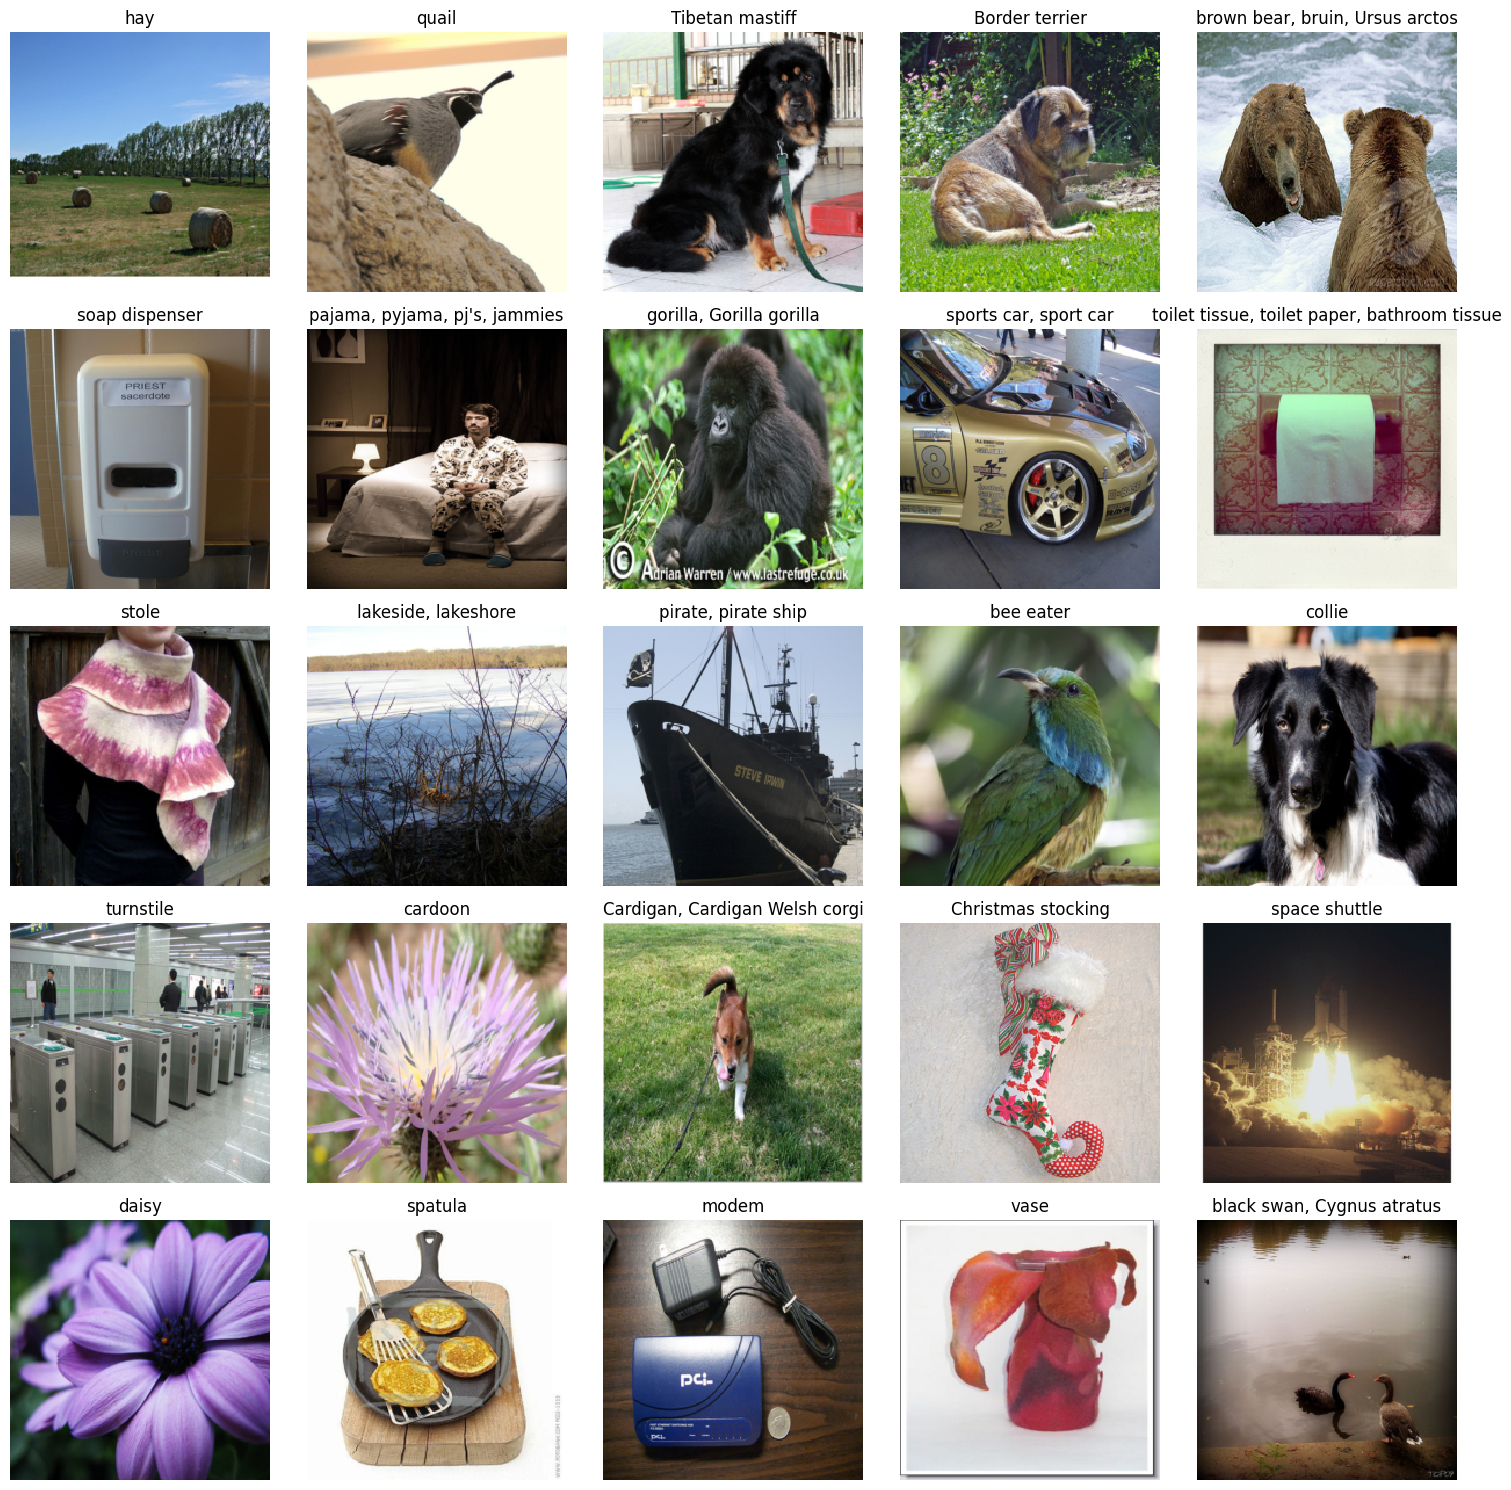

In [16]:
f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis("off")
plt.gcf().tight_layout()

# Saliency Maps

Calculate the saliency map for 5 examples out of the 25 loaded ones following the instructions of the TP guide.

**Hint :** To choose 1 particular value in each row of a matrix, you can do this:

```python
x = torch.Tensor([[0.1, 0.0, 0.5, 0.1, 0.1],
                  [0.0, 0.1, 0.0, 0.6, 0.2],
                  [0.7, 0.1, 0.1, 0.3, 0.0]])
x[np.arange(3), [2, 3, 0]]
# 0.5000
# 0.6000
# 0.7000
#[torch.FloatTensor of size 3]
```


In [18]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # activate gradients on X
    X.requires_grad = True
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image.                                                       #
    # You first want to extract the logits for the correct scores (not the loss),#
    # and then compute the gradients with a backward pass.                       #
    ##############################################################################
    # Forward pass of X.
    scores = model(X)  # (N, C)

    # Extarct the loggits for the correct scores for each image.
    logits = scores.gather(1, y.view(-1, 1)).squeeze()  # (N, )

    # Compute the loss over the correct scores and apply the backward pass.
    # loss = torch.sum(logits)
    # loss.backward()
    # en faite ce qu'on faisait avant donnait toujours la même saliency map, je pense que du coup c'était une sorte de moyenne de toute et non pas une visualization par classe
    # Tous les codes github font comme ça
    logits.backward(torch.ones_like(logits))

    # Compute the absolute value of the X gradients.
    # Saliency Maps requires nonnegative values (gradients).
    saliency = X.grad.abs()  # (N, 3, H, W)

    # Take the maximum value over the 3 input channels (for each of N images).
    saliency = saliency.max(dim=1).values  # (N, H, W)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Test your code with the following function:


/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([90, 89, 98,  1, 21], dtype=torch.int32)

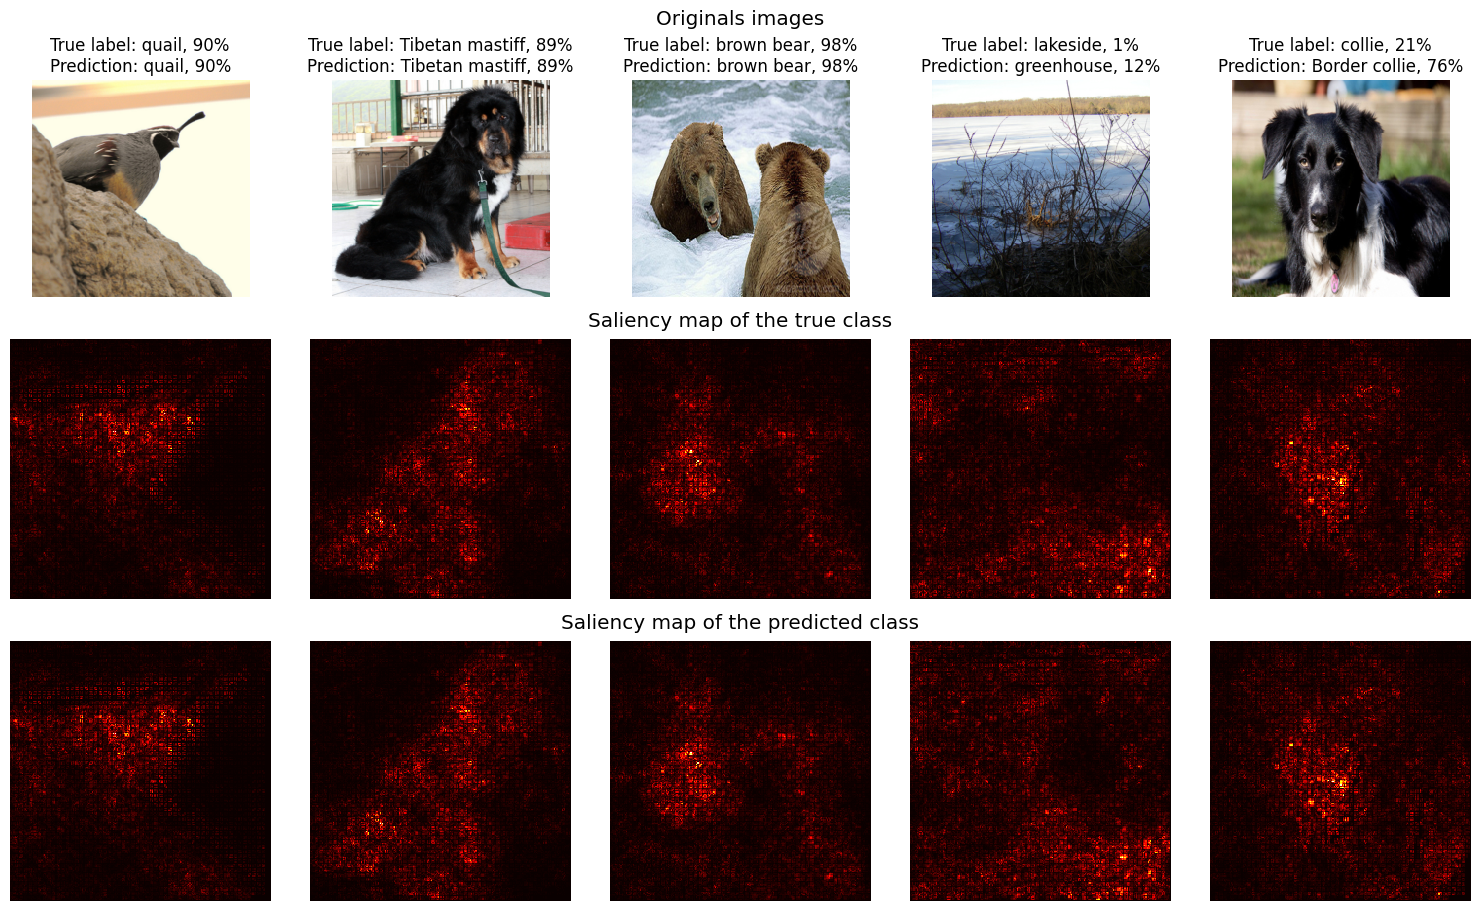

/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([38,  0, 52, 24,  2], dtype=torch.int32)

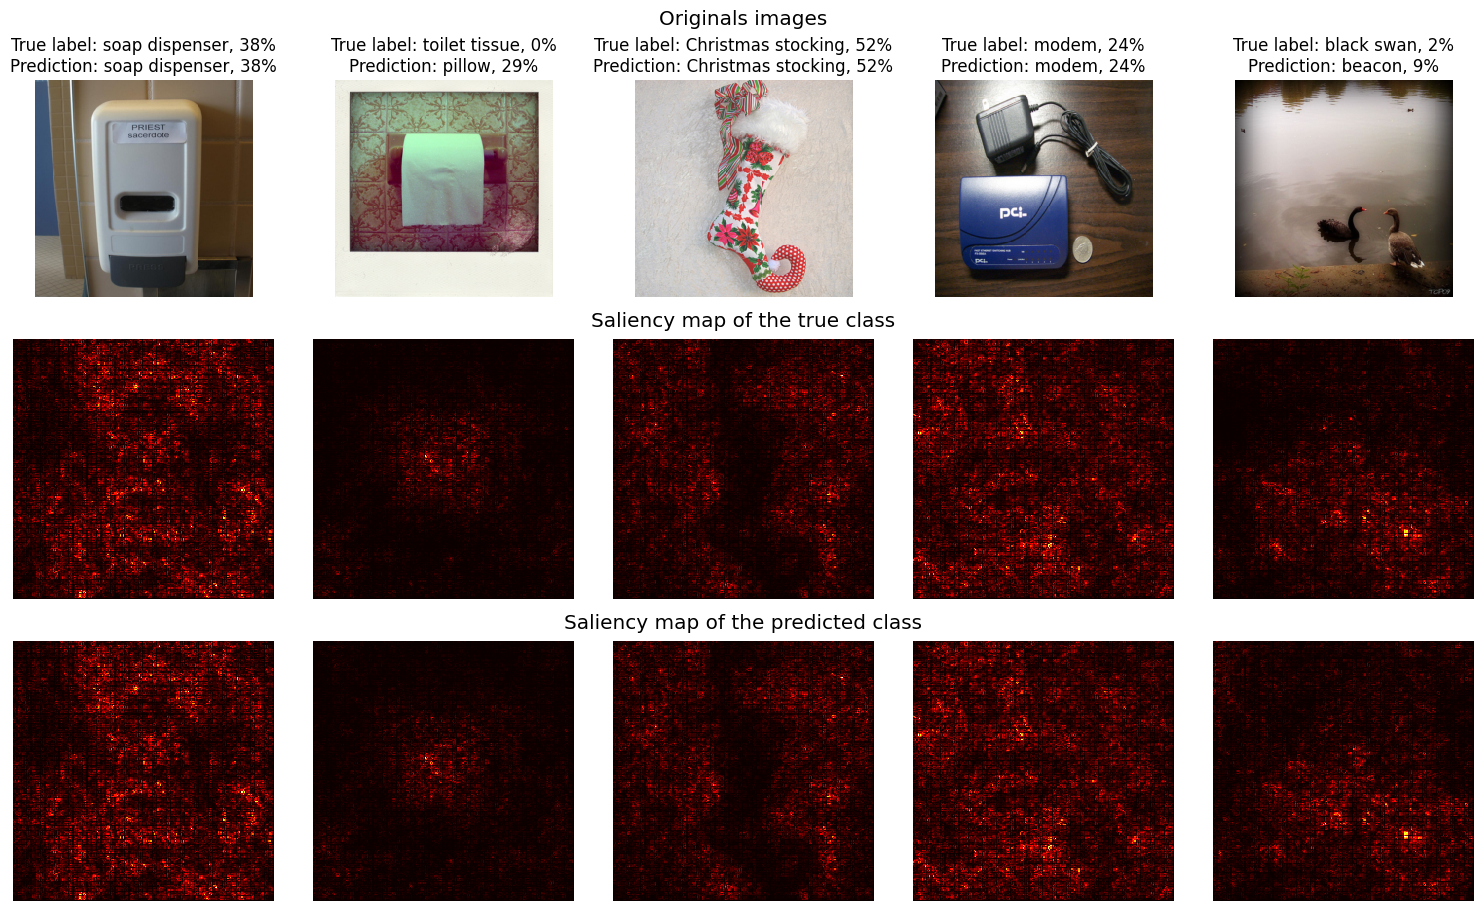

In [19]:
def show_saliency_maps(X, y, model, save_name=None, title=True):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    if title:
        y_hat = model(X_tensor).argmax(1).tolist()
        logit = torch.nn.Softmax()(model(X_tensor)) * 100
        y_hat_proba, y_hat = logit.max(1)
        y_hat = y_hat.int().tolist()
        y_hat_proba = y_hat_proba.int().tolist()
        y_true_proba = logit[np.arange(X_tensor.size(0)), y].int()
        display(y_true_proba)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    saliency_prediction = compute_saliency_maps(X_tensor, torch.tensor(y_hat), model)
    # saliency_prediction = compute_saliency_maps(X_tensor, torch.zeros_like(y_tensor), model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    saliency_prediction = saliency_prediction.numpy()

    # Define the maximum number of columns
    max_columns = 5
    N = X.shape[0]

    # Calculate the required number of rows (2 rows for each set: image and saliency map)
    num_rows = math.ceil(N / max_columns) * 3

    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    # Ploting original image
    subfigs[0].suptitle("Originals images", fontsize="x-large", fontweight="roman")
    axs = subfigs[0].subplots(nrows=1, ncols=max_columns)
    for col, ax in enumerate(axs):
        ax.imshow(X[col])
        ax.axis("off")
        if title:
            true_label = class_names[y[col]].split(",")[0]
            pred_label = class_names[y_hat[col]].split(",")[0]
            ax.set_title(
                f"True label: {true_label}, {y_true_proba[col]}%\nPrediction: {pred_label}, {y_hat_proba[col]}%"
            )

    # Plot the saliency map of the true label
    subfigs[1].suptitle(
        "Saliency map of the true class", fontsize="x-large", fontweight="roman"
    )
    axs = subfigs[1].subplots(nrows=1, ncols=max_columns)
    for col, ax in enumerate(axs):
        ax.imshow(saliency[col], cmap=plt.cm.hot)
        ax.axis("off")

    # Plot the saliency map of the predicted label
    subfigs[2].suptitle(
        "Saliency map of the predicted class", fontsize="x-large", fontweight="roman"
    )
    axs = subfigs[2].subplots(nrows=1, ncols=max_columns)
    for col, ax in enumerate(axs):
        ax.imshow(saliency_prediction[col], cmap=plt.cm.hot)
        ax.axis("off")

    # Adjust figure size based on the number of rows and columns
    # plt.gcf().set_size_inches(max_columns * 3 , num_rows * 1.5 )
    plt.gcf().set_size_inches(15, num_rows * 3)
    # plt.tight_layout()
    if save_name:
        plt.savefig(save_name, dpi=100, bbox_inches="tight")
    plt.show()


def show_saliency_maps_by_errors(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_hat = model(X_tensor).argmax(1).numpy()

    idx_errors = y_hat != y
    idx_good = y_hat == y
    
    # Compute saliency maps for images in X
    show_saliency_maps(X[idx_good], y[idx_good], model, title=False)
    show_saliency_maps(X[idx_errors], y[idx_errors], model, title=False)


def show_saliency_maps_by_class_id(X, y, model, class_id: list, save_name=None):
    idx = np.isin(y, class_id)
    show_saliency_maps(X[idx], y[idx], model, save_name=save_name)


# show_saliency_maps_by_errors(X, y, model)
# show_saliency_maps(X, y, model)
class_id_good_saliency_map = [
    244,  # dog
    294,  # bear
    85,  # bird
    975,  # lac mais regarde à l'opposé de l'endroit comme c'est pas la bonne classe
    231,  # dog bad class
]
class_id_bad_saliency_map = [
    496,  # chrismas stocking
    662,  # modem
    999,  # toilet tissue
    804,  # soap dispenser
    100,  # swan
]
show_saliency_maps_by_class_id(
    X, y, model, class_id_good_saliency_map, save_name="figs/good_saliency_map.pdf"
)
show_saliency_maps_by_class_id(
    X, y, model, class_id_bad_saliency_map, save_name="figs/bad_saliency_map.pdf"
)

In [23]:
def show_saliency_maps(X, y, model, save_names=None, title=True):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    if title:
        y_hat = model(X_tensor).argmax(1).tolist()
        logit = torch.nn.Softmax()(model(X_tensor)) * 100
        y_hat_proba, y_hat = logit.max(1)
        y_hat = y_hat.int().tolist()
        y_hat_proba = y_hat_proba.int().tolist()
        y_true_proba = logit[np.arange(X_tensor.size(0)), y].int()
        display(y_true_proba)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    saliency_prediction = compute_saliency_maps(X_tensor, torch.tensor(y_hat), model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    saliency_prediction = saliency_prediction.numpy()

    # Create and save figures
    if len(save_names) != 3:
        raise ValueError("You must provide three save names for the figures.")
    
    # Save the original images figure
    plt.figure()
    for i in range(X.shape[0]):
        plt.subplot(1, X.shape[0], i + 1)
        plt.imshow(X[i])
        plt.axis("off")
        if title:
            true_label = class_names[y[i]].split(",")[0]
            pred_label = class_names[y_hat[i]].split(",")[0]
            plt.title(
                f"True label: {true_label}, {y_true_proba[i]}%\nPrediction: {pred_label}, {y_hat_proba[i]}%"
            )
    plt.gcf().set_size_inches(15, 5)
    plt.tight_layout()
    plt.savefig(save_names[0], dpi=100, bbox_inches="tight")
    plt.close()

    # Save the saliency map of the true label figure
    plt.figure()
    for i in range(X.shape[0]):
        plt.subplot(1, X.shape[0], i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis("off")
    plt.gcf().set_size_inches(15, 5)
    plt.tight_layout()
    plt.savefig(save_names[1], dpi=100, bbox_inches="tight")
    plt.close()

    # Save the saliency map of the predicted label figure
    plt.figure()
    for i in range(X.shape[0]):
        plt.subplot(1, X.shape[0], i + 1)
        plt.imshow(saliency_prediction[i], cmap=plt.cm.hot)
        plt.axis("off")
    plt.gcf().set_size_inches(15, 5)
    plt.tight_layout()
    plt.savefig(save_names[2], dpi=100, bbox_inches="tight")
    plt.close()

# Modify the show_saliency_maps_by_class_id function to save figures
def show_saliency_maps_by_class_id(X, y, model, class_id: list, save_names=None):
    idx = np.isin(y, class_id)
    show_saliency_maps(X[idx], y[idx], model, save_names=save_names)

# Example usage:
class_id_good_saliency_map = [
    244,  # dog
    294,  # bear
    85,  # bird
    975,  # lac mais regarde à l'opposé de l'endroit comme c'est pas la bonne classe
    231,  # dog bad class
]
class_id_bad_saliency_map = [
    496,  # chrismas stocking
    662,  # modem
    999,  # toilet tissue
    804,  # soap dispenser
    100,  # swan
]
show_saliency_maps_by_class_id(
    X, y, model, class_id_good_saliency_map, save_names=["good_images.pdf", "good_true_class_saliency.pdf", "good_predicted_class_saliency.pdf"]
)
show_saliency_maps_by_class_id(
    X, y, model, class_id_bad_saliency_map, save_names=["bad_images.pdf", "bad_true_class_saliency.pdf", "bad_predicted_class_saliency.pdf"]
)


/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([90, 89, 98,  1, 21], dtype=torch.int32)

/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([38,  0, 52, 24,  2], dtype=torch.int32)

In [24]:
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
show_saliency_maps_by_class_id(
    X, y, vgg16, class_id_good_saliency_map, save_names=["good_images_vgg16.pdf", "good_true_class_saliency_vgg16.pdf", "good_predicted_class_saliency_vgg16.pdf"]
)
show_saliency_maps_by_class_id(
    X, y, vgg16, class_id_bad_saliency_map, save_names=["bad_images_vgg16.pdf", "bad_true_class_saliency_vgg16.pdf", "bad_predicted_class_saliency_vgg16.pdf"]
)

/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([89, 99, 99, 36, 21], dtype=torch.int32)

/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([99, 55, 92, 39, 99], dtype=torch.int32)

# Adversarial Examples (Fooling Images)

Write the code to calculate an image such that it will be classified in a `target_y` different from the real class (by modifying the image and not the network parameters). See the TP guide for instructions.

**The first two blocks will allow you to perform tests in an interactive way** to write and test your code. Once your code seems to work, complete the function in the 3rd block and test on various images in the 4th block.


In [9]:
# Initialize tests
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[0])))
target_y = class_names_to_id["stingray"]  # Desired class
X_fooling = X_tensor.clone()
X_fooling.requires_grad = True
learning_rate = 1

```python
# TODO write your code to test here

# Visualize the image X_folling and its modifications
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(deprocess(X_fooling.clone())).astype(np.uint8))
plt.title("Image X_fooling")
plt.subplot(1, 2, 2)
plt.imshow(np.asarray(deprocess(10 * (X_fooling - X_tensor), should_rescale=False)))
plt.title("Magnified difference with X_tensor (x10)")
plt.show()
```

In [27]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, enable gradients.
    X_fooling = X.clone()
    X_fooling.requires_grad = True

    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * grad / ||grad||_2                                   #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    # HINT: Remember to reset gradients at each step                             #
    # HINT: update shouldn't be tracked by the autograd (see for example         #
    # https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html#sphx-glr-beginner-examples-autograd-two-layer-net-autograd-py #
    ##############################################################################
    for epoch in range(100):
        # Forward pass
        scores = model(X_fooling)  # (1, 1000)

        # Get the predicted class (pred) and its score.
        pred_score, pred = torch.max(scores, axis=1)
        pred_score, pred = pred_score.item(), pred.item()

        # Get the "target_y" score.
        target_score = scores[:, target_y].squeeze()

        # Display some information about the current epoch (iteration).
        print(
            f"Iteration {epoch+1}: target score {target_score.item():.3f}, max score {pred_score:.3f}"
        )

        # Check if the model is fooled, i.e. "predicted class" equals "target_y".
        if pred == target_y:
            print("The model is fooled.")
            print("=" * 50)
            break

        # Backward pass
        target_score.backward()

        # Normalize the gradient (using L2 normalisation in the division).
        X_fooling.grad *= learning_rate / torch.linalg.norm(X_fooling.grad)

        # Update step: gradient ascent. Because the goal is to maximize
        # the predicted score, we addition instead of substracting.
        X_fooling.data += X_fooling.grad.data

        # Re-initialize the gradient to zero (for the next epoch).
        X_fooling.grad.data.zero_()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

Iteration 1: target score 7.414, max score 25.148
Iteration 2: target score 11.349, max score 28.782
Iteration 3: target score 15.755, max score 31.914
Iteration 4: target score 20.144, max score 34.646
Iteration 5: target score 24.712, max score 37.742
Iteration 6: target score 29.002, max score 39.009
Iteration 7: target score 33.530, max score 42.561
Iteration 8: target score 38.698, max score 44.627
Iteration 9: target score 43.151, max score 47.937
Iteration 10: target score 46.877, max score 49.210
Iteration 11: target score 49.869, max score 51.786
Iteration 12: target score 53.213, max score 53.213
The model is fooled.


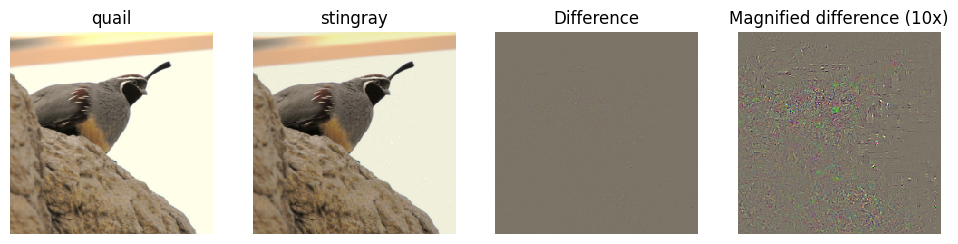

In [28]:
# Index of the image to modify and the target class
idx = 1
target_y = class_names_to_id["stingray"]

# Preparation of tensor X and it's "fooling" version
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx : idx + 1], target_y, model)

# Check the predicted class
scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0], "The model is not fooled!"

# Display
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis("off")

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title("Difference")
plt.axis("off")

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title("Magnified difference (10x)")
plt.axis("off")

plt.gcf().set_size_inches(12, 5)
plt.show()

### Bonus : test with different input images and different target classes.


Iteration 1: target score 5.443, max score 25.148
Iteration 2: target score 7.624, max score 25.776
Iteration 3: target score 10.030, max score 26.089
Iteration 4: target score 11.963, max score 26.061
Iteration 5: target score 14.928, max score 24.203
Iteration 6: target score 18.207, max score 20.936


Iteration 7: target score 20.972, max score 21.963
Iteration 8: target score 23.665, max score 23.665
The model is fooled.


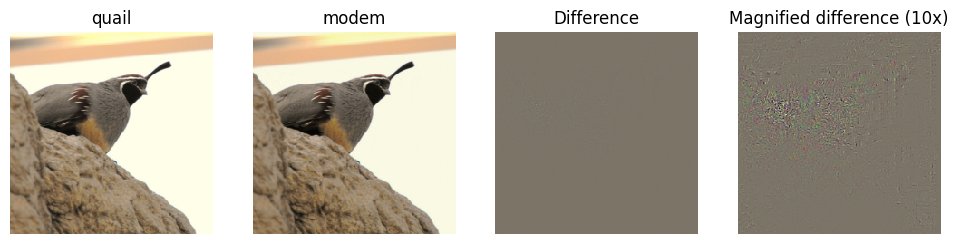

In [33]:
# Index of the image to modify and the target class
idx = 1
target_y = class_names_to_id["modem"]

# Preparation of tensor X and it's "fooling" version
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx : idx + 1], target_y, model)

# Check the predicted class
scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0], "The model is not fooled!"

# Display
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis("off")

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title("Difference")
plt.axis("off")

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title("Magnified difference (10x)")
plt.axis("off")

plt.gcf().set_size_inches(12, 5)
plt.show()

Iteration 1: target score 5.443, max score 25.148
Iteration 2: target score 7.624, max score 25.776
Iteration 3: target score 10.030, max score 26.089
Iteration 4: target score 11.963, max score 26.061
Iteration 5: target score 14.928, max score 24.203
Iteration 6: target score 18.207, max score 20.936
Iteration 7: target score 20.972, max score 21.963


Iteration 8: target score 23.665, max score 23.665
The model is fooled.


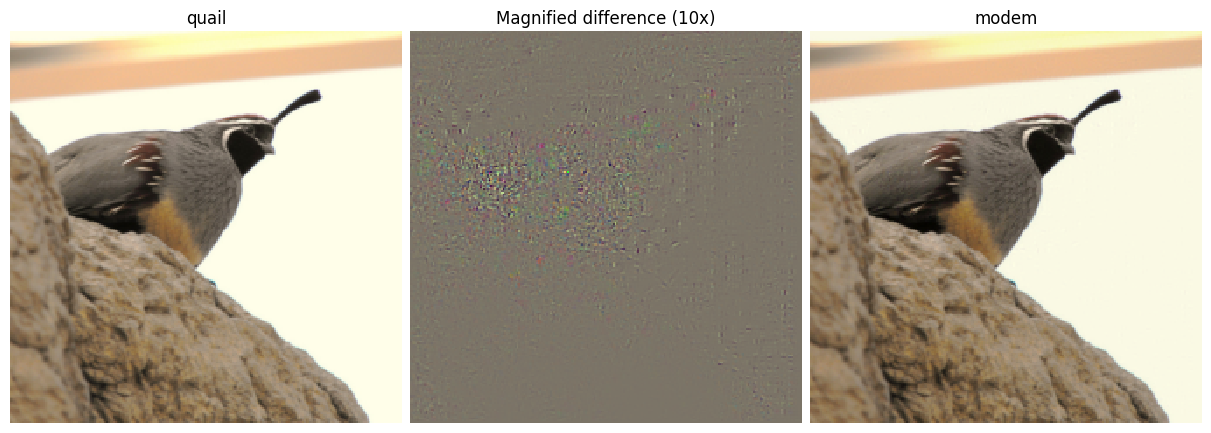

In [64]:
def create_fooling_example(X, y, model, target_class_id, idx=0, save_name=None):
    """
    Create a fooling example and visualize it alongside the original image and differences.

    Args:
    - X: A numpy array containing input images.
    - y: A numpy array containing true labels.
    - model: The neural network model.
    - target_class_id: The target class ID to fool the model into predicting.
    - idx: The index of the image to modify and visualize (default is 0).
    - save_name: The file name to save the visualization (default is None).
    """
    X_original = X[idx]
    # Preparation of tensor X and it's "fooling" version
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    X_fooling = make_fooling_image(X_tensor[idx : idx + 1], target_class_id, model)

    # Check the predicted class
    scores = model(X_fooling)
    assert target_class_id == scores.data.max(1)[1][0], "The model is not fooled!"

    # Convert tensors to numpy arrays
    X_fooling_np = np.asarray(deprocess(X_fooling.clone())).astype(np.uint8)
    X_pre = preprocess(Image.fromarray(X_original))
    # diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
    diff_mag = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))

    # Create subplots for original image, fooling image, difference, and magnified difference
    fig, axs = plt.subplots(1, 3, figsize=(12, 5), layout="constrained")

    images = [X_original, diff_mag, X_fooling_np]
    titles = [class_names[y[idx]], "Magnified difference (10x)", class_names[target_class_id]]

    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    if save_name:
        plt.savefig(save_name, dpi=100, bbox_inches="tight")
    else:
        plt.show()

# Example usage:
idx = 1
target_class_id = class_names_to_id["modem"]
create_fooling_example(X, y, model, target_class_id, idx)


Iteration 1: target score 16.304, max score 38.883
Iteration 2: target score 24.418, max score 43.987
Iteration 3: target score 31.425, max score 47.214
Iteration 4: target score 36.830, max score 50.477
Iteration 5: target score 40.893, max score 53.630
Iteration 6: target score 45.351, max score 55.348
Iteration 7: target score 47.705, max score 57.336
Iteration 8: target score 51.633, max score 59.040
Iteration 9: target score 53.948, max score 61.546
Iteration 10: target score 57.540, max score 63.477
Iteration 11: target score 59.939, max score 65.665
Iteration 12: target score 63.270, max score 67.216
Iteration 13: target score 65.138, max score 69.004
Iteration 14: target score 68.139, max score 71.086
Iteration 15: target score 69.986, max score 72.278
Iteration 16: target score 73.702, max score 75.080
Iteration 17: target score 75.953, max score 75.953
The model is fooled.


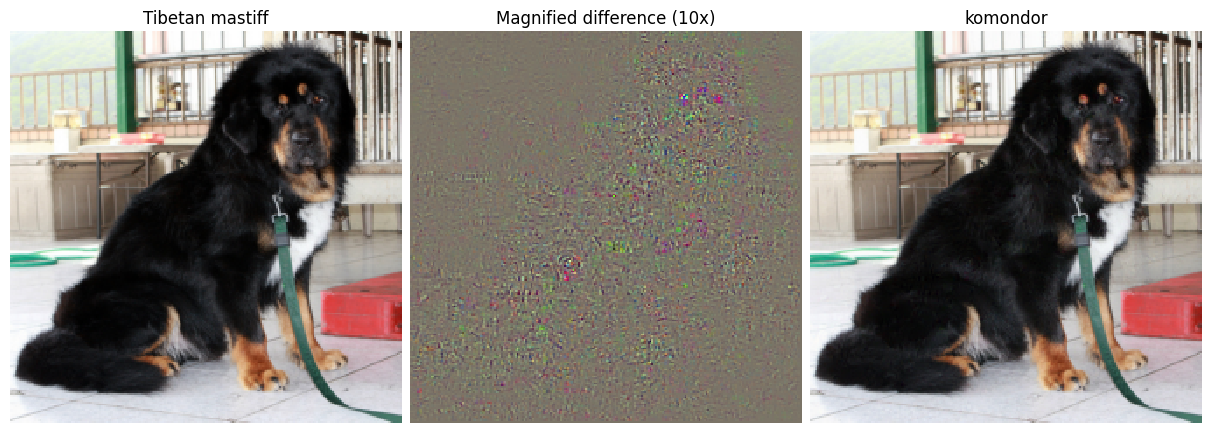

In [70]:
# Example usage:
idx = 2
target_class_id = class_names_to_id["komondor"]
create_fooling_example(X, y, model, target_class_id, idx)

Iteration 1: target score 3.698, max score 24.040
Iteration 2: target score 7.305, max score 24.269
Iteration 3: target score 11.683, max score 25.365
Iteration 4: target score 15.865, max score 26.399
Iteration 5: target score 20.202, max score 26.523
Iteration 6: target score 24.003, max score 26.498
Iteration 7: target score 27.539, max score 27.539
The model is fooled.


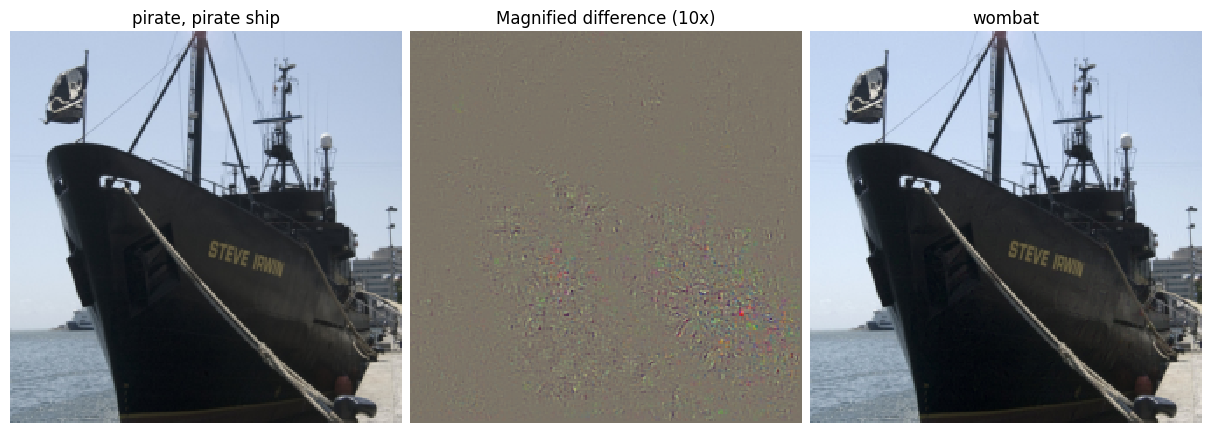

In [73]:
# Example usage:
idx = 12
target_class_id = class_names_to_id["wombat"]
create_fooling_example(X, y, model, target_class_id, idx)

# Class visualization

Write the code which generates an image maximizing the score of a class, subject to a certain number of regularizations. See the TP guide for details.


In [14]:
def create_class_visualization(
    target_y,
    model,
    dtype,
    init_img=None,
    l2_reg=1e-3,
    learning_rate=5,
    num_iterations=200,
    blur_every=10,
    max_jitter=16,
    show_every=25,
    gif=True,
    filename=None
):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    if gif:
        # for GIF creation
        gif_frames = []

    # Randomly initialize the image as a PyTorch Tensor
    if init_img is None:
        img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).detach()
    else:
        img = init_img.clone().mul_(1.0).type(dtype).detach()
    img.requires_grad = True

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img = (jitter(img, ox, oy)).clone().detach()
        img.requires_grad = True

        ########################################################################
        # - TODO: Use the model to compute the gradient of the score for the   #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # - Be very careful about the signs of elements in your code.          #
        # - Advice: compute backward on the raw logits (not the loss), it      #
        # works better                                                         #
        ########################################################################
        # Forward pass
        scores = model(img)  # (1, 1000)
        target_score = scores[:, target_y].squeeze()
        # Add the regularization term (L2 norm is squared).
        target_score -= l2_reg * torch.square(torch.linalg.norm(img))

        # Backward pass
        target_score.backward()

        # Update step: gradient ascent.
        img.data += learning_rate * img.grad.data

        # Re-initialize the gradient of "img" to zero.
        img.grad.data.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        # Undo the random jitter
        img.data.copy_(jitter(img, -ox, -oy))
        img = img.clone()

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)

        if gif:
            # GIF creation
            # Create a buffer, which prevent saving hundreds of images on the disk.
            buf = io.BytesIO()
            # "Show" the image, so we are able to save it.
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title("%s\nIteration %d / %d" % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis("off")
            # Save the image in the buffer.
            plt.savefig(buf, format="png", dpi=100, bbox_inches="tight")
            buf.seek(0)
            # Append the buffered image to an array.
            gif_frames.append(imageio.v2.imread(buf))
            # Close the image, so it's not displayed.
            plt.close()
        else:
            # Periodically show the image
            if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
                plt.imshow(deprocess(img.clone().cpu()))
                class_name = class_names[target_y]
                plt.title("%s\nIteration %d / %d" % (class_name, t + 1, num_iterations))
                plt.gcf().set_size_inches(4, 4)
                plt.axis("off")
                plt.show()

    if filename:
        # Create and save the GIF, using the buffers stored in the array.
        imageio.mimsave(f"figs_propre/{model._get_name()}/{model._get_name()}_{filename}.gif", gif_frames, duration=0.1, loop=0)
        imageio.imsave(f"figs_propre/{model._get_name()}/{model._get_name()}_{filename}_last_frame.png", gif_frames[-1])

    return gif_frames
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)
pass

Test with various classes and starting from random noise:


In [15]:
# target_y = 76  # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# target_y = 113 # Snail
# target_y = np.random.randint(1000) # Classe aléatoire


Same class starting image

In [16]:
# This one is funny
# img_ind = 21 # Spatulla
# target_y = y[img_ind]  
# X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
# out = create_class_visualization(
#     target_y, model, dtype, init_img=X_tensor, num_iterations=300, filename=f"{class_names[target_y]}_animated_same_class_init_img", l2_reg=1e-4,
# )

# With SqueezeNet

## Iterations

Gorilla

KeyboardInterrupt: 

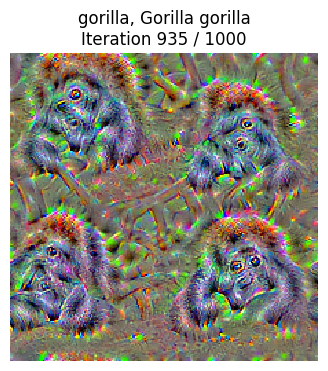

In [17]:
target_y = 366  # Gorilla
create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{model._get_name()}/{model._get_name()}_Gorilla_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

Bee eater

In [ ]:
target_y = 92  # bee eater
create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"bird_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, model, dtype, num_iterations=1000, filename=f"bird_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{model._get_name()}/{model._get_name()}_bird_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

## Regularization

### From noise

Gorilla

In [ ]:
# Initialize test
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="gorrila_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="gorrila_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="gorrila_animated",
)

bee eater

In [ ]:
# Initialize test
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, num_iterations=200, filename="bird_animated",
)

### Starting img

Gorilla

In [ ]:
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img",
)

bee eater

In [ ]:
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img",
)

## Starting image

### Same class

See above

### Different class

In [ ]:
img_ind = 0 # Hai
target_y = 113   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, model, dtype, init_img=X_tensor, num_iterations=500, filename="snail_animated_init_img_reg++", l2_reg=1e-5, blur_every=2
)

# Same with VGG

## Iterations

Gorilla

In [ ]:
target_y = 366  # Gorilla
create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"Gorilla_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{vgg16._get_name()}/{vgg16._get_name()}_Gorilla_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

KeyboardInterrupt: 

Bee eater

In [ ]:
target_y = 92  # bee eater
create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"bird_animated_1000"
)
gif_frames = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=1000, filename=f"bird_animated_1000_regpp_blur", l2_reg=1e-5, blur_every=5
)
for iter in [100, 500]:
    imageio.imsave(f"figs_propre/{vgg16._get_name()}/{vgg16._get_name()}_bird_animated_1000_regpp_blur_{iter}_frame.png", gif_frames[iter-1])

## Regularization

### From noise

Gorilla

In [ ]:
# Initialize test
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="gorrila_animated",
)

bee eater

In [ ]:
# Initialize test
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, num_iterations=200, filename="bird_animated",
)

### Starting img

Gorilla

In [ ]:
img_ind = 7
target_y = y[img_ind]  # Gorilla regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="gorrila_animated_same_init_img",
)

bee eater

In [ ]:
img_ind = 13
target_y = y[img_ind]   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_reg++", l2_reg=1e-5, blur_every=2
)
# no regu
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img_no_reg", l2_reg=0, blur_every=500
)
# regu normale
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="bird_animated_same_init_img",
)

## Starting image

### Same class

See above

### Different class

In [ ]:
img_ind = 0 # Hai
target_y = 113   # bee eater regu ++
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(
    target_y, vgg16, dtype, init_img=X_tensor, num_iterations=200, filename="snail_animated_init_img_reg++", l2_reg=1e-5, blur_every=2
)